In [22]:
# importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import rcParams
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## Basic Implementation of TensorFlow: Classification of Titanic survival
## https://medium.com/@simonli_18826/basic-implementation-of-tensorflow-classification-of-titanic-survival-60a9fbcc7a35

# reading in files

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df = pd.concat([train, test], axis=0, sort=True)
df

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
...,...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236
414,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758
415,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262
416,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309


In [23]:
df['Survived'].value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

In [24]:
result = df.groupby(by=['Survived','Sex']).size().reset_index()
result

,Survived,Sex,0
0,0.0,female,81
1,0.0,male,468
2,1.0,female,233
3,1.0,male,109


<AxesSubplot:xlabel='Survived'>

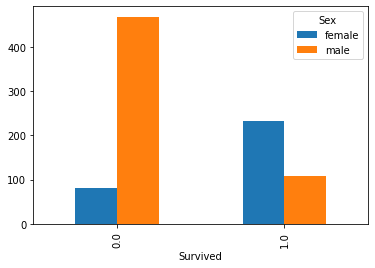

In [25]:
result.rename(columns={0:"count"}, inplace=True)
result.set_index(['Survived','Sex'])['count'].unstack().plot.bar()

In [26]:
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# replacing some titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',
           'Don': 'Mr', 'Mme': 'Mrs', 'Jonkheer': 'Mr', 'Lady': 'Mrs',
           'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
df.replace({'Title': mapping}, inplace=True)

df['Title'].value_counts()

Mr        767
Miss      264
Mrs       201
Master     61
Rev         8
Dr          8
Name: Title, dtype: int64

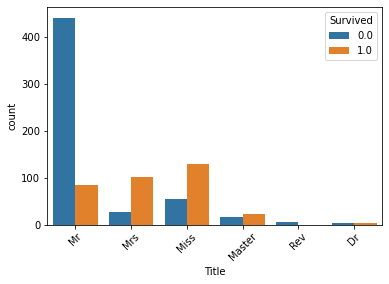

In [27]:
# impute missing Age values using median of Title groups
title_ages = dict(df.groupby('Title')['Age'].median())

# create a column of the average ages
df['age_med'] = df['Title'].apply(lambda x: title_ages[x])

# replace all missing ages with the value in this column
df['Age'].fillna(df['age_med'], inplace=True, )
del df['age_med']

# viz of survival rates of titles

sns.countplot(x='Title', data=df, hue='Survived')
plt.xticks(rotation=45)
plt.show()

In [28]:
# impute missing Fare values using median of Pclass groups
class_fares = dict(df.groupby('Pclass')['Fare'].median())

# create a column of the average fares
df['fare_med'] = df['Pclass'].apply(lambda x: class_fares[x])

# replace all missing fares with the value in this column
df['Fare'].fillna(df['fare_med'], inplace=True, )
del df['fare_med']

In [29]:
df['Embarked'].fillna(method='backfill', inplace=True)

df['Family_Size'] = df['Parch'] + df['SibSp']

In [30]:
train = df[pd.notnull(df['Survived'])]
test = df[pd.isnull(df['Survived'])]

# importing for tensorflow

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from numpy.random import seed

In [31]:
df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

continuous = ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Family_Size']

scaler = StandardScaler()

for var in continuous:
    df[var] = df[var].astype('float64')
    df[var] = scaler.fit_transform(df[var].values.reshape(-1, 1))
   
df.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title,Family_Size
0,-0.574635,S,-0.503176,-0.445,0.841916,male,0.481288,0.0,Mr,0.073352
1,0.641140,C,0.734809,-0.445,-1.546098,female,0.481288,1.0,Mrs,0.073352
2,-0.270692,S,-0.490126,-0.445,0.841916,female,-0.479087,1.0,Miss,-0.558346
3,0.413182,S,0.383263,-0.445,-1.546098,female,0.481288,1.0,Mrs,0.073352
4,0.413182,S,-0.487709,-0.445,0.841916,male,-0.479087,0.0,Mr,-0.558346


In [32]:
X_train = df[pd.notnull(df['Survived'])].drop(['Survived'], axis=1)
y_train = df[pd.notnull(df['Survived'])]['Survived']
X_test = df[pd.isnull(df['Survived'])].drop(['Survived'], axis=1)

In [36]:
import tensorflow as tf

Sex = tf.feature_column.categorical_column_with_vocabulary_list("Sex", ["female", "male"])
Embarked = tf.feature_column.categorical_column_with_vocabulary_list("Embarked", ["S", "C", "Q"])
Title = tf.feature_column.categorical_column_with_vocabulary_list("Title", ['Mr', 'Mrs', 'Miss', 'Master', 'Rev', 'Dr'])
Age = tf.feature_column.numeric_column("Age")
Fare = tf.feature_column.numeric_column("Fare")
Parch = tf.feature_column.numeric_column("Parch")
Pclass = tf.feature_column.numeric_column("Pclass")
SibSp = tf.feature_column.numeric_column("SibSp")
Family_Size = tf.feature_column.numeric_column("Family_Size")

feat_cols = [Sex, Embarked, Title, Age, Fare, Parch, Pclass, SibSp, Family_Size]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

input_func=tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_train,
                                               y=y_train,
                                               batch_size=100,
                                               num_epochs=None,
                                               shuffle=True)


model = tf.estimator.LinearClassifier(feature_columns = feat_cols)



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp4q6bo_pc', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [38]:
model.train(input_fn=input_func, max_steps=10000)

pred_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_val,batch_size=len(X_val),shuffle=False)

predictions = list(model.predict(input_fn=pred_fn))
final_preds = []
for pred in predictions:
    final_preds.append(pred['class_ids'][0])
    
from sklearn.metrics import classification_report
print(classification_report(y_val,final_preds))

INFO:tensorflow:Skipping training since max_steps has already saved.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp4q6bo_pc/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
              precision    recall  f1-score   support

         0.0       0.80      0.88      0.84        67
         1.0       0.80      0.68      0.74        47

    accuracy                           0.80       114
   macro avg       0.80      0.78      0.79       114
weighted avg       0.80      0.80      0.80       114

